In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import io
import ipywidgets as widgets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from PIL import Image
from IPython.display import display

In [3]:
# Gunakan GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 10

In [5]:
data_dir = "/content/drive/MyDrive/data/dataset"

# Data Transformations (Augmentation & Normalization)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset dan Dataloader
dataset = ImageFolder(data_dir, transform=train_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class_names = dataset.classes
num_classes = len(class_names)

In [6]:
print(f"Train Dataset: {len(train_dataset)}")
print(f"Validation Dataset: {len(val_dataset)}")
print(f"Class Names: {class_names}")

Train Dataset: 2000
Validation Dataset: 500
Class Names: ['beng-beng', 'blastoz', 'kalpa', 'top', 'waffle']


<Axes: title={'center': "['top', 'waffle', 'beng-beng', 'beng-beng']"}>

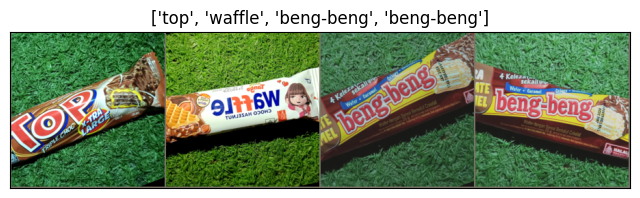

In [7]:
def imshow(inp, title=None, ax=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # ubah format tensor ke HWC
    mean = np.array([0.485, 0.456, 0.406])  # normalisasi bawaan ImageNet
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # denormalisasi
    inp = np.clip(inp, 0, 1)  # batasi antara 0-1 agar bisa ditampilkan

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))
    ax.imshow(inp)
    ax.set_xticks([])
    ax.set_yticks([])
    if title is not None:
        ax.set_title(title)
    return ax

inputs, classes = next(iter(train_loader))

out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

In [8]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=learning_rate)

In [10]:
for epoch in range(num_epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")

Epoch 1, Loss: 33.4946, Accuracy: 0.9030
Epoch 2, Loss: 5.0364, Accuracy: 1.0000
Epoch 3, Loss: 2.6924, Accuracy: 1.0000
Epoch 4, Loss: 1.5214, Accuracy: 1.0000
Epoch 5, Loss: 1.2901, Accuracy: 1.0000
Epoch 6, Loss: 0.8186, Accuracy: 1.0000
Epoch 7, Loss: 0.6939, Accuracy: 1.0000
Epoch 8, Loss: 0.6545, Accuracy: 1.0000
Epoch 9, Loss: 0.5838, Accuracy: 0.9995
Epoch 10, Loss: 0.4256, Accuracy: 1.0000


In [11]:
model.eval()
correct = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, 1)
        correct += (predicted == labels).sum().item()

val_acc = correct / len(val_loader.dataset)
print(f"Validation Accuracy: {val_acc:.4f}")

Validation Accuracy: 1.0000


FileUpload(value={}, accept='image/*', description='Upload')

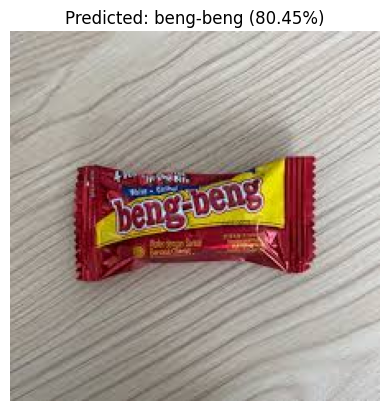

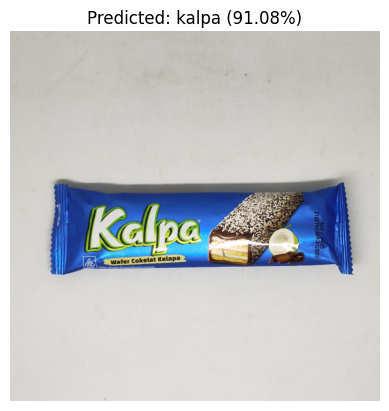

In [18]:
def predict_image(image_bytes):
    image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    input_tensor = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = F.softmax(output, dim=1)
        pred = torch.argmax(probabilities, dim=1)
        confidence = probabilities[0][pred.item()].item() * 100

    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {class_names[pred.item()]} ({confidence:.2f}%)")
    plt.show()

upload = widgets.FileUpload(accept='image/*', multiple=False)

def on_upload_change(change):
    if upload.value:
        file_info = list(upload.value.values())[0]
        content = file_info['content']
        predict_image(content)

upload.observe(on_upload_change, names='value')
display(upload)
